Lets first load few libraries. lphys is where we define our utility functions.

In [1]:
import lphys
import uproot
# import probfit
# import iminuit
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import awkward as ak
import scipy
from iminuit import cost, Minuit
from scipy.stats import multivariate_normal as mvnorm
from numba_stats import truncnorm, truncexpon, norm, expon, voigt, crystalball

We will load two files: one with data, the other with simulation. You can change the datafile to use the electrons dataset instead. You can also change the simulation for the CMS simulation.

In [2]:
# input files
data_file = "doubleMu2011_ntuple.root" # "doubleEl2011_Ntuple.root"
simu_file = "delpheAnalysisZ.root" # "ppNeutralCurrentFullsim_ntuple.root"

In [3]:
datafile = uproot.open(data_file)
simufile = uproot.open(simu_file)
datatree = datafile['LPHY2131analysis/WeakBosonsAnalysis']
simutree = simufile['LPHY2131analysis/WeakBosonsAnalysis']

We take the selection that we obtained previously, and we use it to derive the Invariant Mass distribution.

In [4]:
# Here is an example to start with. Cuts should be tuned and complemented by others.

# cuts
def selection(events, branches=None):
    # first filter on the number of objects
    filter = (events.nMuons==2) & (events.nElectrons==0) & (events.nJets<10)
    selected = events[filter]
    # then apply a cut on the muon Pt
    filter = (selected.MuonsPt[:,0]>10) & (selected.MuonsPt[:,1]>2) 
    selected = selected[filter]
    # cut on the isolation
    filter = (selected.MuonIsolation[:,0]<0.5) & (selected.MuonIsolation[:,1]<0.5) 
    selected = selected[filter]
   
    if branches:
        return selected[branches]
    else:
        return selected

In [5]:
selected_data = lphys.analyzeTree(datatree,["invMass"],selection=selection, step_size="10 MB")
selected_simu = lphys.analyzeTree(simutree,["invMass"],selection=selection, step_size="10 MB")

We want to determine the shape of the Z peak, to measure the Z boson mass and width. 
For that, we will repeat what we just did but for a different Probability Density Function.
For the background, we will keep the parametrization that we used to measure the yield.
For the signal, different options could be tried:
- Normalized relativistic Breit Wigner, probfit.pdf.rtv_breitwigner(double x, double m, double gamma) 
- Crystalball, probfit.pdf.crystalball(double x, double alpha, double n, double mean, double sigma) 
- Voigt (BW convoluted with a Gaussian)
- ...
See https://probfit.readthedocs.io/en/latest/api.html#builtin-pdf for more examples.

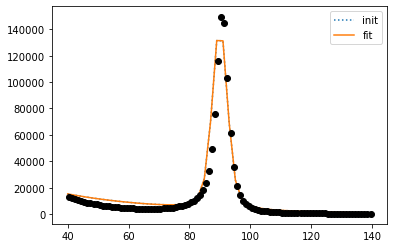

In [7]:
# This defines the binning for the fit and the display below.
xlim=(40,140)
nbins=100

data = ak.to_numpy(selected_data["invMass"]).astype('double')

n, xe = np.histogram(data, bins=nbins, range=xlim) #n: bin content; xe: bin edges
cx = 0.5 * (xe[1:] + xe[:-1]) # bin centers
dx = np.diff(xe) # bin width

plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(*xlim)
plt.plot(xm, density(xm, *[p.value for p in m.init_params])[1] * dx[0],
         ls=":", label="init")
plt.plot(xm, density(xm, *m.values)[1] * dx[0], label="fit")
plt.legend();

In [8]:
def density(x, s, b, beta, m, loc, scale, tau):
    return (s * crystalball.pdf(x, beta, m, loc, scale) +
            b * truncexpon.pdf(x, *xlim, 0, tau))

def integral(x, s, b, beta, m, loc, scale, tau):
    return (s * crystalball.cdf(x, beta, m, loc, scale) +
            b * truncexpon.cdf(x, *xlim, 0, tau))

c = cost.ExtendedBinnedNLL(n, xe, integral)
m = Minuit(c, s=1E6, b=0.5E6, beta=1, m=2, loc=90, scale=2, tau=35)
m.limits["s", "b", "beta", "m", "loc", "scale", "tau"] = (0, None)
m.interactive()

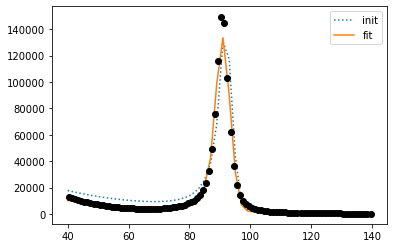

In [9]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(*xlim)
plt.plot(xm, density(xm, *[p.value for p in m.init_params]),
         ls=":", label="init")
plt.plot(xm, density(xm, *m.values), label="fit")
plt.legend();

In [35]:
def density(x, s, b, gamma,mu, sigma, tau):
    return s + b, (s * voigt.pdf(x, gamma, mu, sigma) + 
        b * truncexpon.pdf(x, *xlim, 0, tau))

def integral(x, s, b, gamma,mu, sigma, tau):
    return density(x,s,b,gamma,mu,sigma,tau)[1].cumsum()

c = cost.ExtendedBinnedNLL(n, xe, integral)
m = Minuit(c, s=1E6, b=0.5E6, gamma=1, mu=90, sigma=2, tau=35)
m.limits["s", "b", "tau"] = (0, None)
m.limits["gamma","sigma"] = (0.5,5)
m.limits["mu"] = (60,120)

# Visualize signal and background components with different colors
class Plotter:
    def __init__(self, cost):
        self.cost = cost

    def __call__(self, args):
        xe = self.cost.xe
        n = self.cost.data
        cx = 0.5 * (xe[1:] + xe[:-1])
        plt.errorbar(cx, n, n ** 0.5, fmt="ok")
        sm = np.diff(self.cost.scaled_cdf(xe, args[0], 0, args[2], args[3], args[4], 0))
        bm = np.diff(self.cost.scaled_cdf(xe, 0, args[1], 0, 0, 0, args[5]))
        plt.stairs(bm, xe, fill=True, color="C1")
        plt.stairs(bm + sm, xe, baseline = bm, fill=True, color="C0")
        plt.yscale('log')

m.interactive(Plotter(c))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.533e+04 (chi2/ndof = 163.1)│              Nfcn = 811              │
│ EDM = 1.18e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  997.4e3  │   1.2e3   │   -1.2e3   │   1.2e3    │    0    │         │       │
│ 1 │ b     │  234.2e3  │   0.7e3   │   -0.7e3   │   0.7e3    │    0    │         │       │
│ 2 │ gamma │   1.671   │   0.006   │   -0.006   │   0.006    │   0.5   │    5    │       │
│ 3 │ mu    │  91.1933  │  0.0030   │  -0.0030   │   0.0030   │   60    │   120   │       │
│ 4 │ sigma │   1.035   │   0.009   │   -0.009   │   0.009    │   0.5   │    5    │       │
│ 5 │ tau   │   18.65   │   0.08    │   -0.08    │    0.08    │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │           s           │           b           │         gamma         │          mu           │         sigma         │          tau          │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -1.2e3   │   1.2e3   │  -0.7e3   │   0.7e3   │  -0.006   │   0.006   │  -0.003   │   0.003   │  -0.009   │   0.009   │   -0.08   │   0.08    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │         s         b     gamma        mu     sigma       tau │
├───────┼─────────────────────────────────────────────────────────────┤
│     s │  1.34e+06 -2.77e+05      2.34   -0.0743     -2.63     -37.6 │
│     b │ -2.77e+05  4.83e+05     -1.84    0.0764      2.03      32.3 │
│ gamma │      2.34     -1.84   3.3e-05  3.57e-07 -4.04e-05 -0.000241 │
│    mu │   -0.0743    0.0764  3.57e-07  8.92e-06 -2.33e-06  8.42e-06 │
│ sigma │     -2.63      2.03 -4.04e-05 -2.33e-06  7.47e-05  0.000261 │
│   tau │     -37.6      32.3 -0.000241  8.42e-06  0.000261   0.00677 │
└───────┴─────────────────────────────────────────────────────────────┘

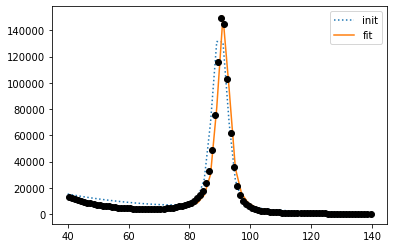

In [37]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(*xlim)
plt.plot(xm, density(xm, *[p.value for p in m.init_params])[1] * dx[0],
         ls=":", label="init")
plt.plot(xm, density(xm, *m.values)[1] * dx[0], label="fit")
plt.legend();
m.minos()

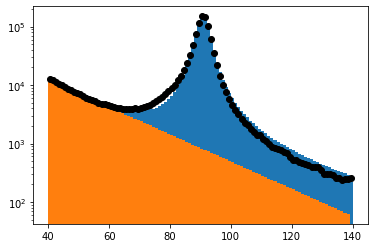

In [46]:
Plotter(c)(m.values)

100% (21 of 21) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


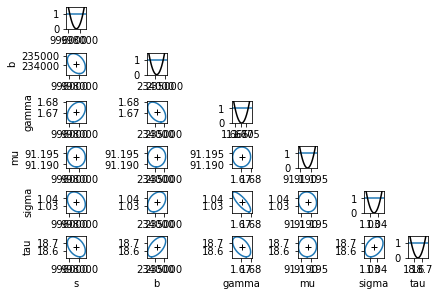

In [73]:
m.draw_mnmatrix();

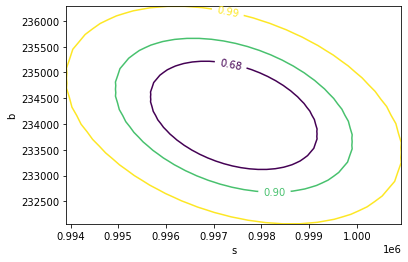

In [79]:
#plt.figure(figsize=(8, 6))
m.draw_mncontour("s", "b", cl=(0.68, 0.9, 0.99));

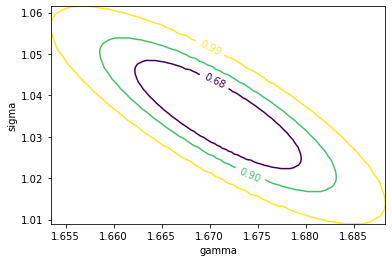

In [80]:
#plt.figure(figsize=(8, 6))
m.draw_mncontour("gamma", "sigma", cl=(0.68, 0.9, 0.99));

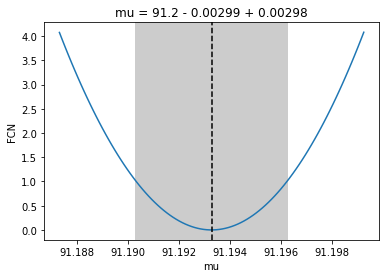

In [78]:
m.draw_profile("mu");

Let's now prepare the fit.
For each parameter we should provide initial (guess) values and/or a range of acceptable values.
This is done by constructing a "Minuit" object.
Initial values are directly set using the name of the variable, while the range is set using ]```limit_[varname]=(low,high)```.

We can then draw the initial pdf together with the data.

Finally, we do the fit using the MIGRAD algorithm and we display the result.

Lets do a better plot:

In [81]:
def useFit(migradfit):
    for param in migradfit[1]:
        globals()[param.name] = param.value
        globals()[f"{param.name}_unc"] = param.error
useFit(m)

bkg    = lphys.sample(lphys.randomSample(lambda x: background_pdf(x,b,Nb),xlim,nbins,size=10000),
                      "background","red",integral=Nb)
signal = lphys.sample(selected_simu["invMass"],
                      "signal MC","blue",integral=Ns)

bkg_model = lphys.curve(lambda x:background_pdf(x,b,Nb),'Bkg shape',"orange",4)
tot_model = lphys.curve(lambda x:background_pdf(x,b,Nb)+signal_pdf(x,m,gamma,sigma,Ns),'S+B fit','cyan',4)

lphys.plot(selected_data["invMass"], [bkg,signal], [bkg_model,tot_model],
           xlim, 'Invariant mass (GeV)', 'Probability', 
           nbins, islog=True, color='g', density=False)

TypeError: 'Minuit' object is not subscriptable

Before concluding, we should look more closely at the fit results.
Want to extract quantities like the purity or the number of Z bosons, but we are also interested in the uncertainties and correlations, that we can access through the covariance matrix.

In [42]:
N = len(selected_data)
print("Summary data:\n")
print(f"Purity: { Ns/N*100:.2f} +/- {Ns_unc/N*100:.2f} %")
print(f"Selection efficiency: {len(selected_simu)/simutree.num_entries*100} %")
print(f"N_Z = {Ns:.0f} +/- {Ns_unc:.0f}")
print(f"N_bkg = {Nb:.0f} +/- {Nb_unc:.0f}")
print(f"N_data = {N}")

cov = minuit.np_covariance()
corr = lphys.correlation_from_covariance(cov)
fig, axs = plt.subplots(1, 2,figsize=(25, 10), sharey=False)
lphys.matrixPlot(fig,axs[1],corr,iminuit.describe(binned_likelihood),mrange=(-1,1))
lphys.matrixPlot(fig,axs[0],cov,iminuit.describe(binned_likelihood),"Blues",mrange="log")
axs[0].set_title('Covariance Matrix')
axs[1].set_title('Correlation Matrix')
plt.show()

Summary data:



NameError: name 'Ns' is not defined